# DCGAN

NOTE: The archiectures below have some differences from the original paper
      (literally all the things in CNNs the paper said not to do!
        [use striding instead of pooling, batchnorm, relu, remove fully connected layers])
      will fix and retrain later

Sources:
    
https://github.com/jacobgil/keras-dcgan    

https://arxiv.org/abs/1511.06434

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import fashion_mnist
import numpy as np
from PIL import Image
import argparse
import math
import os

## Generator
The generator will take an input vector z of random noise, and generate an image.
This network is trained with the loss calculated from how the discriminator classifies the generated images.

In [36]:
def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, units=1024))
    model.add(Activation('tanh'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model

## Discriminator

The discriminator will take an image and classify it as fake or real.

In [4]:
def discriminator_model():
    model = Sequential()
    model.add(
            Conv2D(64, (5, 5),
            padding='same',
            input_shape=(28, 28, 1))
            )
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

Because we are training the generator on loss computed from the discriminator's output,
we combine the models for convenience (more on training process below).

In [5]:
def generator_containing_discriminator(g, d):
    model = Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model

In [6]:
# Utility function combine generated images into a tiled image
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

## Training

Training is composed of these steps:

1. Feed (predict) vectors of random noise through generator to get generated images.
2. Train discriminator with real images and generated images.
3. Feed (predict) same vectors of random noise through discriminator, and train generator with this loss.

In [7]:
def train(EPOCHS, BATCH_SIZE, TRAIN_PROCESS_DIR):
    os.makedirs(TRAIN_PROCESS_DIR, exist_ok=True)

    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    X_train = X_train[:, :, :, None]
    X_test = X_test[:, :, :, None]
    # X_train = X_train.reshape((X_train.shape, 1) + X_train.shape[1:])
    d = discriminator_model()
    g = generator_model()
    d_on_g = generator_containing_discriminator(g, d)
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)
    d.trainable = True
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    for epoch in range(EPOCHS):
        print("Epoch is", epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                file_name = "%d_%d.png" % (epoch, index)
                Image.fromarray(image.astype(np.uint8)).save(
                        os.path.join(TRAIN_PROCESS_DIR, file_name))
            X = np.concatenate((image_batch, generated_images))
            y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
            d_loss = d.train_on_batch(X, y)
            print("batch %d d_loss : %f" % (index, d_loss))
            noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, [1] * BATCH_SIZE)
            d.trainable = True
            print("batch %d g_loss : %f" % (index, g_loss))
            if index % 10 == 9:
                g.save_weights('generator', True)
                d.save_weights('discriminator', True)

## Generating Images

Generating images is done just by feeding the generator random noise.
Using the discriminator we can filter out the most "realistic" images.

In [37]:
def generate(BATCH_SIZE, nice=False):
    g = generator_model()
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    g.load_weights('generator')
    if nice:
        d = discriminator_model()
        d.compile(loss='binary_crossentropy', optimizer="SGD")
        d.load_weights('discriminator')
        noise = np.random.uniform(-1, 1, (BATCH_SIZE*20, 100))
        generated_images = g.predict(noise, verbose=1)
        d_pret = d.predict(generated_images, verbose=1)
        index = np.arange(0, BATCH_SIZE*20)
        index.resize((BATCH_SIZE*20, 1))
        pre_with_index = list(np.append(d_pret, index, axis=1))
        pre_with_index.sort(key=lambda x: x[0], reverse=True)
        nice_images = np.zeros((BATCH_SIZE,) + generated_images.shape[1:3], dtype=np.float32)
        nice_images = nice_images[:, :, :, None]
        for i in range(BATCH_SIZE):
            idx = int(pre_with_index[i][1])
            nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]
        images = nice_images
    else:
        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        images = g.predict(noise, verbose=1)
    images = images*127.5+127.5
    return np.squeeze(images)


# Fashion MNIST
https://github.com/zalandoresearch/fashion-mnist

We will be using the fashion mnist set to train the DCGAN.

In [10]:
(X,_), (_, _) = fashion_mnist.load_data()

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_gallery(images, titles=None, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap='gray')
        if titles:
            plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

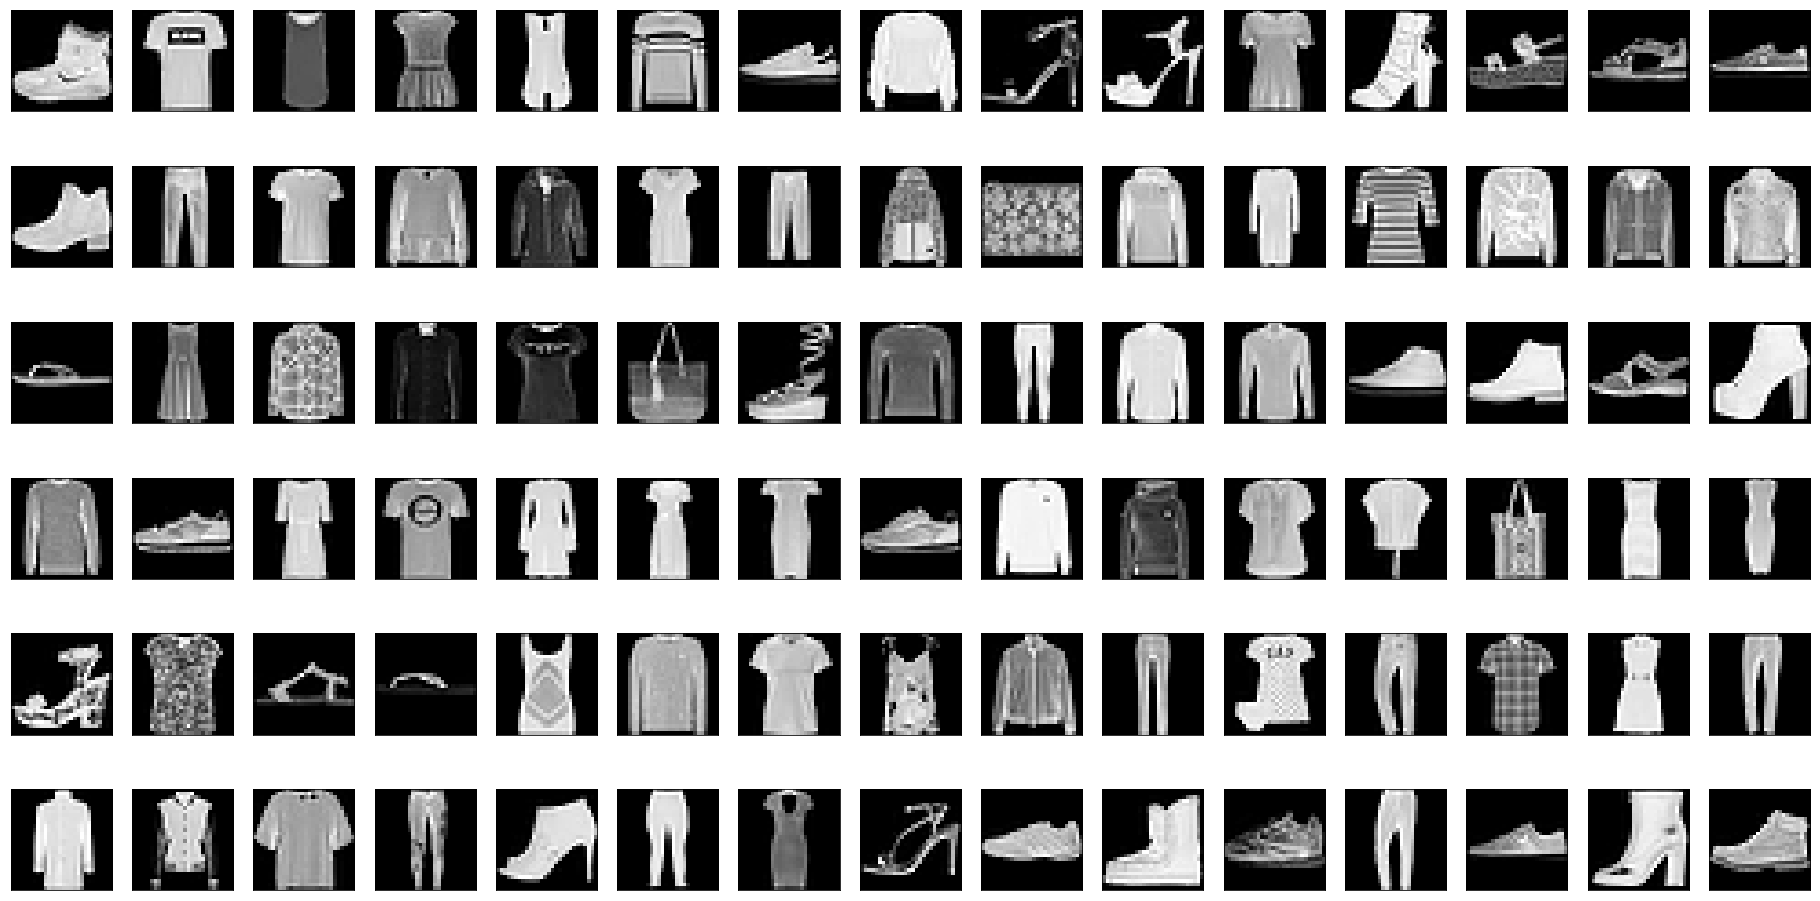

In [21]:
plot_gallery(X, n_row=6, n_col=15)

# Generated images

128/128 [==============================] - 0s     


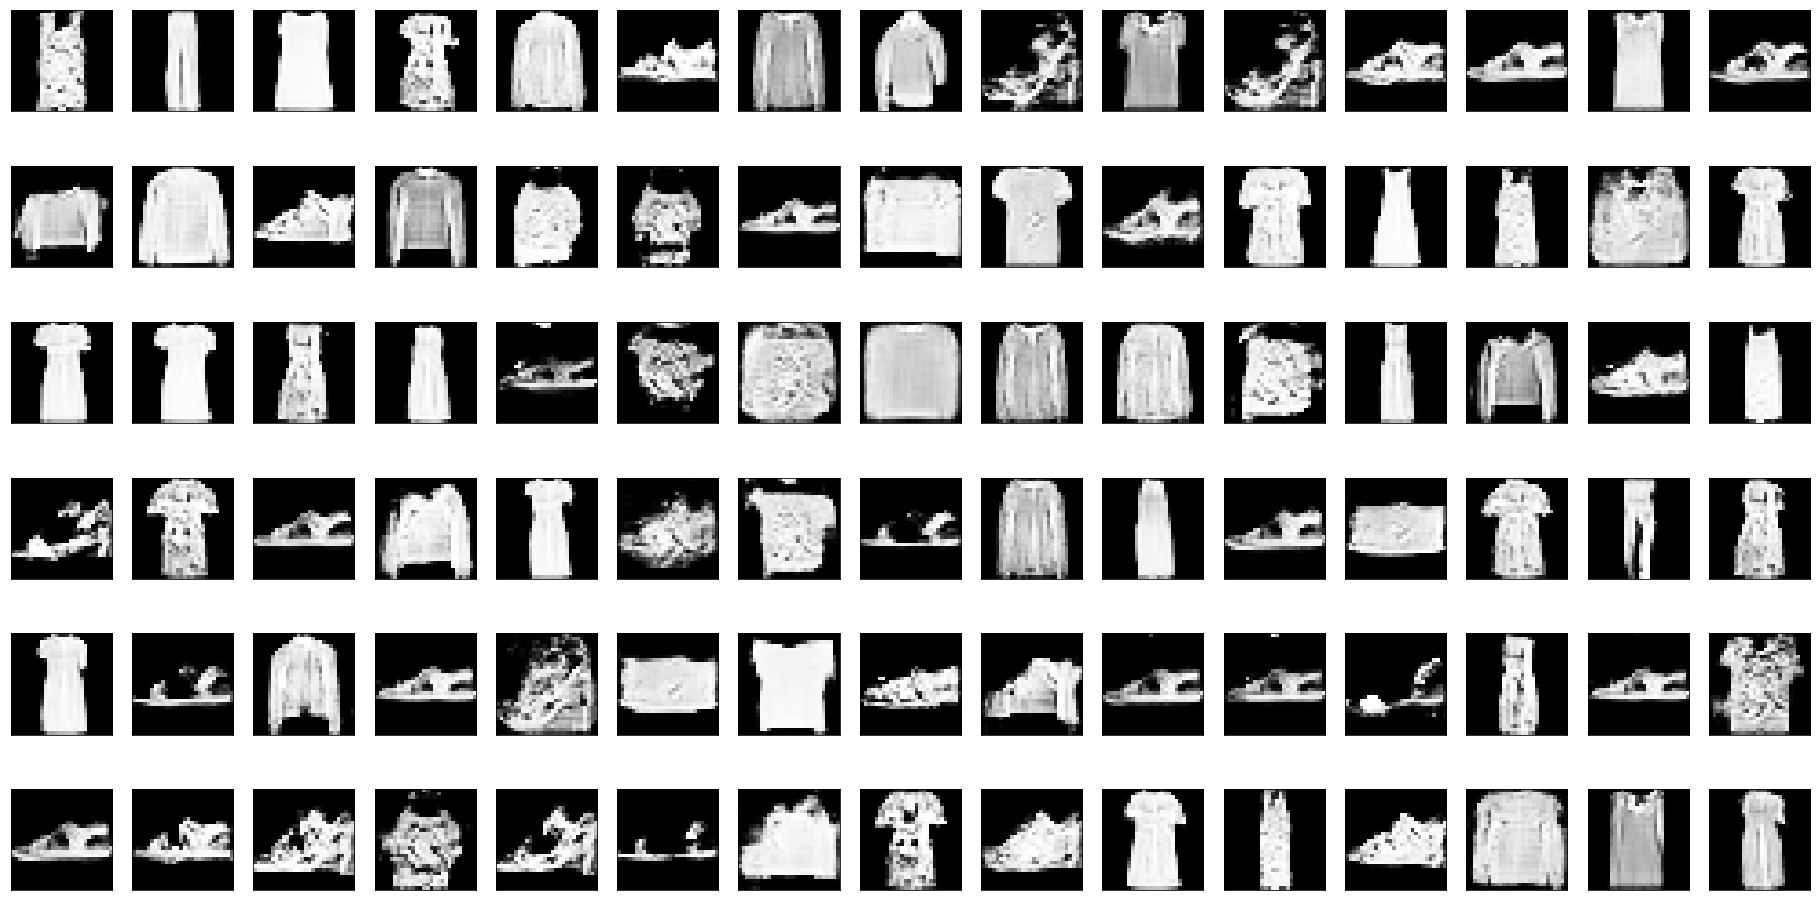

In [38]:
generated_images = generate(128)
plot_gallery(generated_images, n_row=6, n_col=15)

## Top 5% "realistic" according to discriminator

2528/2560 [============================>.] - ETA: 0s

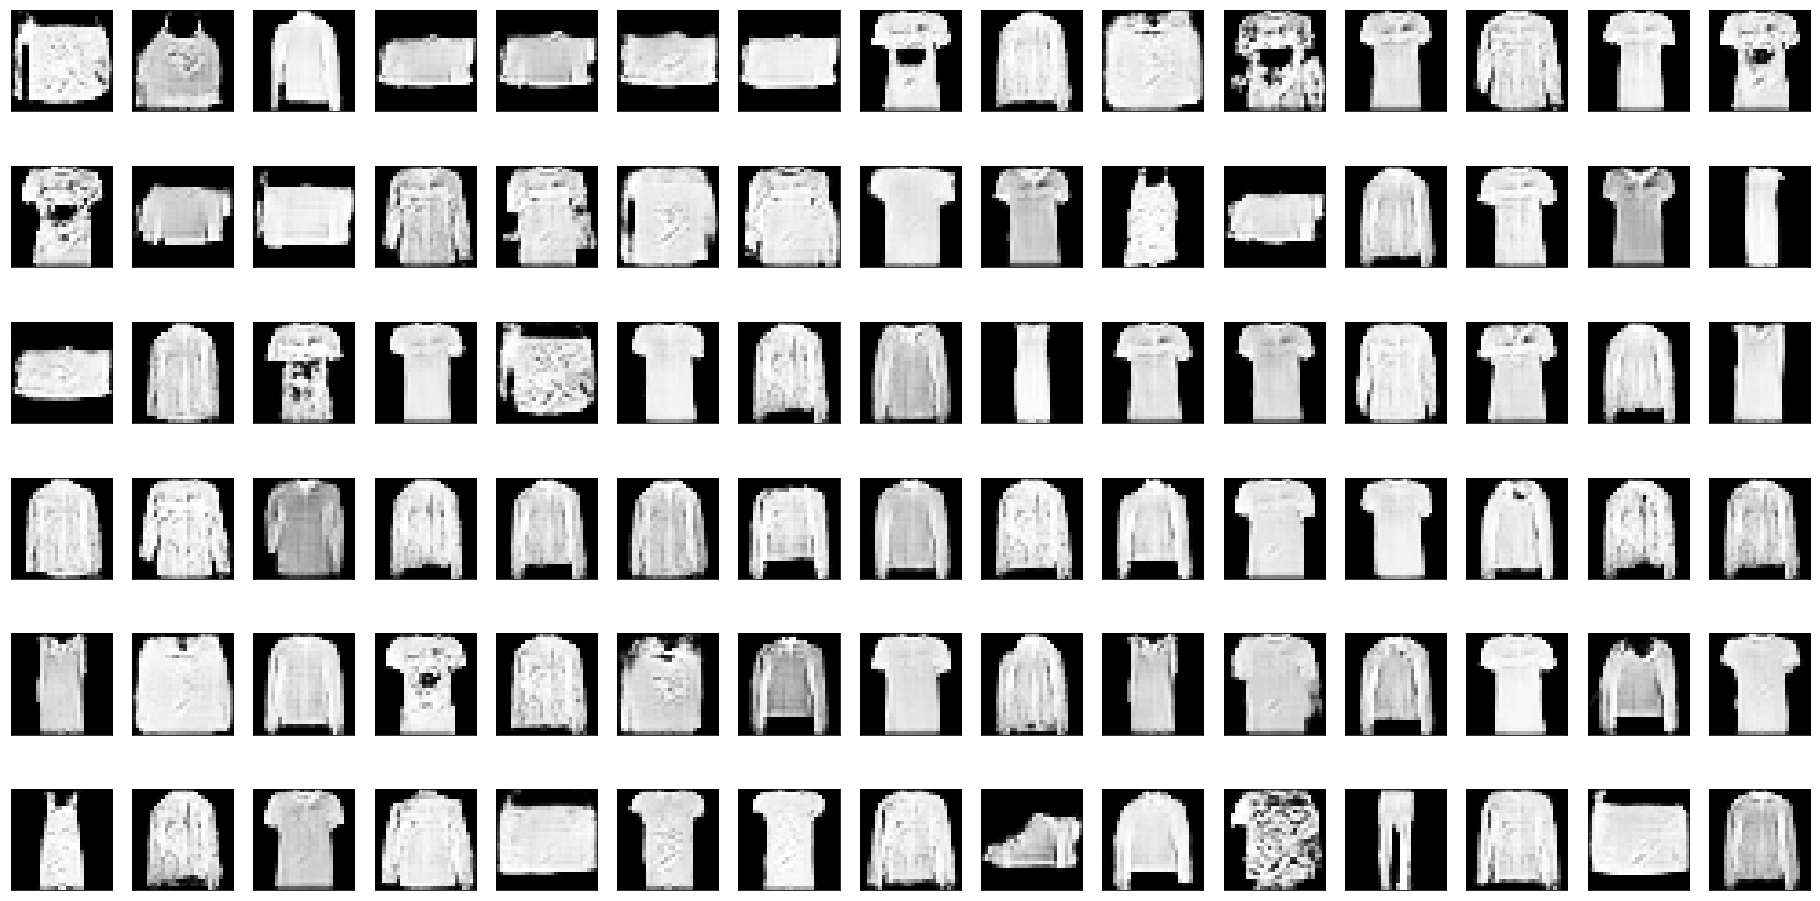

In [39]:
generated_images = generate(128, nice=True)
plot_gallery(generated_images, n_row=6, n_col=15)

# Using the discriminator as a classifier

In [77]:
#TODO: fix this
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

d = discriminator_model()
d.compile(loss='binary_crossentropy', optimizer="SGD")
d.load_weights('discriminator')

base_model = Model(d.input, d.layers[6].output)
for layer in base_model.layers:
    layer.trainable = False
    
top_model = Sequential()
top_model.add(Dense(256, activation='relu', input_shape=model.output_shape[1:]))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.compile('adam', 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

(_,_), (X, y) = fashion_mnist.load_data()
X = X[:, :, :, None]

X_train, X_test, y_train, y_test = train_test_split(X, y)

model.fit(X_train, y_train)

Epoch 1/1


InvalidArgumentError: Matrix size-incompatible: In[0]: [32,3200], In[1]: [1,256]
	 [[Node: sequential_37/dense_68/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](flatten_21/Reshape, dense_68/kernel/read)]]

Caused by op 'sequential_37/dense_68/MatMul', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-77-164d570ff3cb>", line 19, in <module>
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
  File "/home/justin/.local/lib/python3.6/site-packages/keras/engine/topology.py", line 602, in __call__
    # Actually call the layer, collecting output(s), mask(s), and shape(s).
  File "/home/justin/.local/lib/python3.6/site-packages/keras/models.py", line 532, in call
    # Arguments
  File "/home/justin/.local/lib/python3.6/site-packages/keras/engine/topology.py", line 2058, in call
    if cache_key in self._output_tensor_cache:
  File "/home/justin/.local/lib/python3.6/site-packages/keras/engine/topology.py", line 2209, in run_internal_graph
    if has_arg(layer.call, 'mask'):
  File "/home/justin/.local/lib/python3.6/site-packages/keras/layers/core.py", line 841, in call
  File "/home/justin/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 998, in dot
    A tensor, dot product of `x` and `y`.
  File "/home/justin/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1765, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/justin/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1454, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/home/justin/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/justin/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/justin/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Matrix size-incompatible: In[0]: [32,3200], In[1]: [1,256]
	 [[Node: sequential_37/dense_68/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](flatten_21/Reshape, dense_68/kernel/read)]]


(10000, 28, 28, 1)